# Object localisation project with VGG16 - part 2

In this notebook a model is created that detects objects from varying sizes and flipped objects from an image. The object may or may not appear at all in the image, and there are three different classes of objects that may appear. Code is applied based on Lazyprogrammer's advanced computer vision course.

## 1. Build the model for Step 1 : objects may not appear

In [13]:
import numpy as np
import imageio
from matplotlib import pyplot as plt
from matplotlib.patches import Rectangle
from keras.layers import Flatten, Dense, Concatenate
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.preprocessing import image
from keras.applications import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.losses import binary_crossentropy, categorical_crossentropy
from skimage.transform import resize

In [14]:
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png

File ‘charmander-tight.png’ already there; not retrieving.



In [3]:
!ls

charmander-tight.png  sample_data


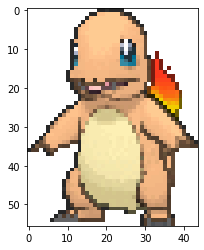

In [3]:
ch = imageio.imread('charmander-tight.png')
plt.imshow(ch)
plt.show()

In [4]:
POKE_DIM = 200
ch = np.array(ch)
CH_H, CH_W, CH_C = ch.shape

In [5]:
def custom_loss(y_true, y_pred):
  # target is a 5-tuple
  # (row, col, depth, width, object_appeared)
  bce = binary_crossentropy(y_true[:, :-1], y_pred[:, :-1])
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1])
  return 2 * bce * y_true[:, -1] + 0.5 * bce2

In [15]:
def make_model():
  vgg = VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x = Dense(5, activation='sigmoid')(x)
  model = Model(vgg.input, x)
#   model.compile(loss=custom_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))
  return model

In [7]:
!wget -nc https://lazyprogrammer.me/course_files/backgrounds.zip

--2020-12-11 07:53:03--  https://lazyprogrammer.me/course_files/backgrounds.zip
Resolving lazyprogrammer.me (lazyprogrammer.me)... 104.31.80.48, 104.31.81.48, 172.67.213.166, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|104.31.80.48|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 494000 (482K) [application/zip]
Saving to: ‘backgrounds.zip’

backgrounds.zip     100%[===================>] 482.42K   801KB/s    in 0.6s    

2020-12-11 07:53:04 (801 KB/s) - ‘backgrounds.zip’ saved [494000/494000]



In [8]:
!unzip -n backgrounds.zip

Archive:  backgrounds.zip
   creating: backgrounds/
  inflating: backgrounds/8.jpg       
   creating: __MACOSX/
   creating: __MACOSX/backgrounds/
  inflating: __MACOSX/backgrounds/._8.jpg  
  inflating: backgrounds/9.jpg       
  inflating: __MACOSX/backgrounds/._9.jpg  
  inflating: backgrounds/14.jpg      
  inflating: __MACOSX/backgrounds/._14.jpg  
  inflating: backgrounds/15.jpg      
  inflating: __MACOSX/backgrounds/._15.jpg  
  inflating: backgrounds/12.jpg      
  inflating: __MACOSX/backgrounds/._12.jpg  
  inflating: backgrounds/13.jpg      
  inflating: __MACOSX/backgrounds/._13.jpg  
  inflating: backgrounds/11.jpg      
  inflating: __MACOSX/backgrounds/._11.jpg  
  inflating: backgrounds/10.jpg      
  inflating: __MACOSX/backgrounds/._10.jpg  
  inflating: backgrounds/4.jpg       
  inflating: __MACOSX/backgrounds/._4.jpg  
  inflating: backgrounds/5.jpg       
  inflating: __MACOSX/backgrounds/._5.jpg  
  inflating: backgrounds/7.jpg       
  inflating: __MACOSX/back

In [9]:
from glob import glob
backgrounds = []

background_files = glob('backgrounds/*.jpg')
for f in background_files:
  # Note: they may not all be the same size
  bg = np.array(image.load_img(f))
  backgrounds.append(bg)

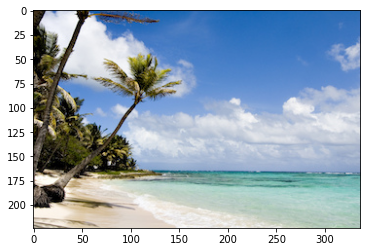

In [10]:
plt.imshow(backgrounds[3])

In [11]:
def pokemon_generator_bg(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 5))
      
      for i in range(batch_size):
        # select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
        
        appear = (np.random.random() < 0.5)
        if appear:
      
          # resize charmander - make it bigger or smaller
          scale = 0.5 + np.random.random()
          new_height = int(CH_H * scale)
          new_width = int(CH_W * scale)
          obj = resize(
              ch,
              (new_height, new_width),
              preserve_range=True).astype(np.uint8) # keep it from 0..255

          # maybe flip
          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          # choose a random location to store the object
          row0 = np.random.randint(POKE_DIM - new_height)
          col0 = np.random.randint(POKE_DIM - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          # can't 'just' assign obj to a slice of X
          # since the transparent parts will be black (0)
          mask = (obj[:,:,3] == 0) # find where the pokemon is 0
          bg_slice = X[i,row0:row1,col0:col1,:] # where we want to place `obj`
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
          bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
          X[i,row0:row1,col0:col1,:] = bg_slice # put the slice back
        
          # make targets
          Y[i,0] = row0/POKE_DIM
          Y[i,1] = col0/POKE_DIM

          # later: make the pokemon different sizes
          Y[i,2] = (row1 - row0)/POKE_DIM
          Y[i,3] = (col1 - col0)/POKE_DIM
        
        # did the pokemon appear?
        Y[i,4] = appear
      
      yield X / 255., Y

In [13]:
xx = None
yy = None
for x, y in pokemon_generator_bg():
  xx, yy = x, y
  break

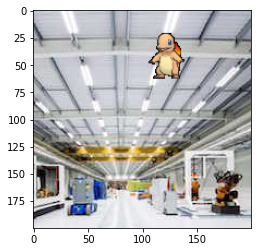

In [14]:
plt.imshow(xx[5]);

In [17]:
model = make_model()
model.fit(
    pokemon_generator_bg(),
    steps_per_epoch=50,
    epochs=5,
)

Epoch 1/5
50/50 [==============================] - 32s 640ms/step - loss: 0.6392
Epoch 2/5
50/50 [==============================] - 34s 671ms/step - loss: 0.5451
Epoch 3/5
50/50 [==============================] - 35s 709ms/step - loss: 0.5625
Epoch 4/5
50/50 [==============================] - 36s 715ms/step - loss: 0.5523
Epoch 5/5
50/50 [==============================] - 35s 701ms/step - loss: 0.5548


In [18]:
# Make predictions
def pokemon_prediction_bg():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
  
  appear = (np.random.random() < 0.5)
  if appear:
        
    # resize charmander - make it bigger or smaller
    scale = 0.5 + np.random.random()
    new_height = int(CH_H * scale)
    new_width = int(CH_W * scale)
    obj = resize(
        ch,
        (new_height, new_width),
        preserve_range=True).astype(np.uint8) # keep it from 0..255

    # maybe flip
    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    # choose a random location to store the object
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

    # can't 'just' assign obj to a slice of X
    # since the transparent parts will be black (0)
    mask = (obj[:,:,3] == 0) # find where the pokemon is 0
    bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
    bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
    x[row0:row1,col0:col1,:] = bg_slice # put the slice back
    print("true:", row0, col0, row1, col1)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]
  
  # Plot
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  
  # Draw the box
  if p[4] > 0.5:
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    print("pred:", row0, col0, row1, col1)
    rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  else:
    print("pred: no object")
  plt.show()

true: 26 32 95 86
pred: 25 31 88 89


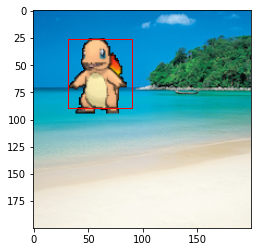

In [19]:
pokemon_prediction_bg()

## 2. Build the model for Step 2 : objects are from multiple classes

In [20]:
# Download several objects to enable multiple classes of objects
!wget -nc https://lazyprogrammer.me/course_files/charmander-tight.png
!wget -nc https://lazyprogrammer.me/course_files/bulbasaur-tight.png
!wget -nc https://lazyprogrammer.me/course_files/squirtle-tight.png

File ‘charmander-tight.png’ already there; not retrieving.

--2020-12-11 08:00:39--  https://lazyprogrammer.me/course_files/bulbasaur-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.81.48, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3435 (3.4K) [image/png]
Saving to: ‘bulbasaur-tight.png’

bulbasaur-tight.png 100%[===================>]   3.35K  --.-KB/s    in 0s      

2020-12-11 08:00:39 (65.4 MB/s) - ‘bulbasaur-tight.png’ saved [3435/3435]

--2020-12-11 08:00:39--  https://lazyprogrammer.me/course_files/squirtle-tight.png
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.31.81.48, 104.31.80.48, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 3333 (3.3K) [image/png]
Saving to: ‘squirtle-tight.png’

squirtle-tight.png  10

In [17]:
!ls

backgrounds	 bulbasaur-tight.png   __MACOSX     squirtle-tight.png
backgrounds.zip  charmander-tight.png  sample_data


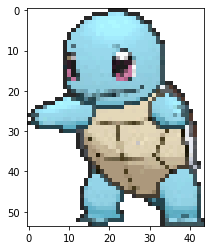

In [21]:
ch = imageio.imread('charmander-tight.png')
bb = imageio.imread('bulbasaur-tight.png')
sq = imageio.imread('squirtle-tight.png')
plt.imshow(sq)
plt.show()

In [22]:
POKE_DIM = 200
ch = np.array(ch)
bb = np.array(bb)
sq = np.array(sq)
CH_H, CH_W, CH_C = ch.shape
BB_H, BB_W, BB_C = bb.shape
SQ_H, SQ_W, SQ_C = sq.shape

# useful store these in an array
poke_data = [
  [ch, CH_H, CH_W, CH_C],
  [bb, BB_H, BB_W, BB_C],
  [sq, SQ_H, SQ_W, SQ_C],
]
class_names = ['Charmander', 'Bulbasaur', 'Squirtle']

In [23]:
def custom_loss(y_true, y_pred):
  # target is a 8-tuple
  # (row, col, depth, width, class1, class2, class3, object_appeared)

  bce = binary_crossentropy(y_true[:, :4], y_pred[:, :4]) # location
  cce = categorical_crossentropy(y_true[:, 4:7], y_pred[:, 4:7]) # object class
  bce2 = binary_crossentropy(y_true[:, -1], y_pred[:, -1]) # object appeared

  return bce * y_true[:, -1] + cce * y_true[:, -1] + 0.5 * bce2

In [24]:
def make_model2():
  vgg = VGG16(
    input_shape=[POKE_DIM, POKE_DIM, 3],
    include_top=False,
    weights='imagenet')
  x = Flatten()(vgg.output)
  x1 = Dense(4, activation='sigmoid')(x) # location
  x2 = Dense(3, activation='softmax')(x) # object class
  x3 = Dense(1, activation='sigmoid')(x) # object appeared
  x = Concatenate()([x1, x2, x3])
  model = Model(vgg.input, x)
#   model.compile(loss=custom_loss, optimizer=SGD(learning_rate=0.01, momentum=0.9))
  model.compile(loss=custom_loss, optimizer=Adam(lr=0.0001))
  return model

In [25]:
def pokemon_generator_multiclass(batch_size=64):
  # generate image and targets
  while True:
    # Each epoch will have 50 batches. Why? No reason
    for _ in range(50):
      X = np.zeros((batch_size, POKE_DIM, POKE_DIM, 3))
      Y = np.zeros((batch_size, 8))
      
      for i in range(batch_size):
        # select a random background
        bg_idx = np.random.choice(len(backgrounds))
        bg = backgrounds[bg_idx]
        bg_h, bg_w, _ = bg.shape
        rnd_h = np.random.randint(bg_h - POKE_DIM)
        rnd_w = np.random.randint(bg_w - POKE_DIM)
        X[i] = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
        
        # 25% no object, 25% + 25% + 25% for the 3 classes
        appear = (np.random.random() < 0.75)
        if appear:
          
          # choose a pokemon
          pk_idx = np.random.randint(3)
          pk, h, w, _ = poke_data[pk_idx]

          # resize object - make it bigger or smaller
          scale = 0.5 + np.random.random()
          new_height = int(h * scale)
          new_width = int(w * scale)
          obj = resize(
              pk,
              (new_height, new_width),
              preserve_range=True).astype(np.uint8) # keep it from 0..255

          # maybe flip
          if np.random.random() < 0.5:
            obj = np.fliplr(obj)

          # choose a random location to store the object
          row0 = np.random.randint(POKE_DIM - new_height)
          col0 = np.random.randint(POKE_DIM - new_width)
          row1 = row0 + new_height
          col1 = col0 + new_width

          # can't 'just' assign obj to a slice of X
          # since the transparent parts will be black (0)
          mask = (obj[:,:,3] == 0) # find where the pokemon is 0
          bg_slice = X[i,row0:row1,col0:col1,:] # where we want to place `obj`
          bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
          bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
          X[i,row0:row1,col0:col1,:] = bg_slice # put the slice back
        
          # make targets

          # location
          Y[i,0] = row0/POKE_DIM
          Y[i,1] = col0/POKE_DIM
          Y[i,2] = (row1 - row0)/POKE_DIM
          Y[i,3] = (col1 - col0)/POKE_DIM

          # class
          Y[i,4 + pk_idx] = 1
        
        # did the pokemon appear?
        Y[i,7] = appear
      
      yield X / 255., Y

In [26]:
xx = None
yy = None
for x, y in pokemon_generator_multiclass():
  xx, yy = x, y
  break

[0. 0. 0. 0. 0. 0. 0. 0.]
percent no obj: 0.3125
percent charmander: 0.234375
percent bulbasaur: 0.234375
percent squirtle: 0.21875


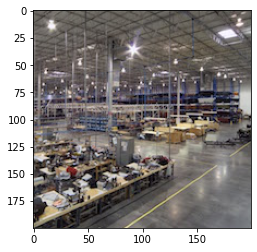

In [27]:
n = yy.shape[0]
idx = np.random.randint(n)
plt.imshow(xx[idx]);
print(yy[idx])
print("percent no obj:", (yy[:,7] == 0).sum() / n)
print("percent charmander:", yy[:,4].sum() / n)
print("percent bulbasaur:", yy[:,5].sum() / n)
print("percent squirtle:", yy[:,6].sum() / n)

In [28]:
model = make_model2()
model.fit(
    pokemon_generator_multiclass(),
    steps_per_epoch=50,
    epochs=5,
)

Epoch 1/5
50/50 [==============================] - 36s 721ms/step - loss: 0.7697
Epoch 2/5
50/50 [==============================] - 36s 718ms/step - loss: 0.4142
Epoch 3/5
50/50 [==============================] - 35s 706ms/step - loss: 0.4113
Epoch 4/5
50/50 [==============================] - 36s 716ms/step - loss: 0.4064
Epoch 5/5
50/50 [==============================] - 35s 707ms/step - loss: 0.4143


In [29]:
# Make predictions
def pokemon_prediction_multiclass():
  # select a random background
  bg_idx = np.random.choice(len(backgrounds))
  bg = backgrounds[bg_idx]
  bg_h, bg_w, _ = bg.shape
  rnd_h = np.random.randint(bg_h - POKE_DIM)
  rnd_w = np.random.randint(bg_w - POKE_DIM)
  x = bg[rnd_h:rnd_h+POKE_DIM,rnd_w:rnd_w+POKE_DIM].copy()
  
  appear = (np.random.random() < 0.75)
  if appear:

    # choose a pokemon
    pk_idx = np.random.randint(3)
    pk, h, w, _ = poke_data[pk_idx]
        
    # resize charmander - make it bigger or smaller
    scale = 0.5 + np.random.random()
    new_height = int(h * scale)
    new_width = int(w * scale)
    obj = resize(
        pk,
        (new_height, new_width),
        preserve_range=True).astype(np.uint8) # keep it from 0..255

    # maybe flip
    if np.random.random() < 0.5:
      obj = np.fliplr(obj)

    # choose a random location to store the object
    row0 = np.random.randint(POKE_DIM - new_height)
    col0 = np.random.randint(POKE_DIM - new_width)
    row1 = row0 + new_height
    col1 = col0 + new_width

    # can't 'just' assign obj to a slice of X
    # since the transparent parts will be black (0)
    mask = (obj[:,:,3] == 0) # find where the pokemon is 0
    bg_slice = x[row0:row1,col0:col1,:] # where we want to place `obj`
    bg_slice = np.expand_dims(mask, -1) * bg_slice # (h,w,1) x (h,w,3)
    bg_slice += obj[:,:,:3] # "add" the pokemon to the slice
    x[row0:row1,col0:col1,:] = bg_slice # put the slice back
    actual_class = class_names[pk_idx]
    print("true:", row0, col0, row1, col1, actual_class)
  
  # Predict
  X = np.expand_dims(x, 0) / 255.
  p = model.predict(X)[0]
  
  # Plot
  fig, ax = plt.subplots(1)
  ax.imshow(x.astype(np.uint8))
  
  # Draw the box
  if p[-1] > 0.5:
    row0 = int(p[0]*POKE_DIM)
    col0 = int(p[1]*POKE_DIM)
    row1 = int(row0 + p[2]*POKE_DIM)
    col1 = int(col0 + p[3]*POKE_DIM)
    class_pred_idx = np.argmax(p[4:7])
    class_pred = class_names[class_pred_idx]
    print("pred:", row0, col0, row1, col1, class_pred)
    rect = Rectangle(
        (p[1]*POKE_DIM, p[0]*POKE_DIM),
        p[3]*POKE_DIM, p[2]*POKE_DIM,linewidth=1,edgecolor='r',facecolor='none')
    ax.add_patch(rect)
  else:
        print("pred: no object")
  plt.show()

true: 134 108 161 130 Squirtle
pred: 116 101 144 124 Squirtle


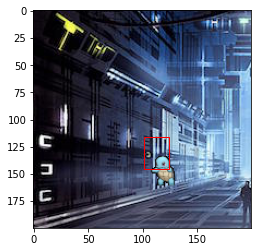

In [30]:
pokemon_prediction_multiclass()